Dependencies

In [ ]:
%pip install jax
%pip install numpy
%pip install gymnax
%pip install distrax
%pip install optax
%pip install flax==0.10.4
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 6.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827729 sha256=2b0d602b66fa82532d69daed6f2caa9ff8febcee246e92709935c3185e6cc039
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from typing import Any, Dict, Optional, Tuple, Union
import chex
from flax import struct
import jax
from jax import lax
import jax.numpy as jnp
import gymnax
from gymnax.environments import environment
from gymnax.environments import spaces

# 定义格子类型的常量
START = 0   # S
FROZEN = 1  # F
HOLE = 2    # H
GOAL = 3    # G

@struct.dataclass
class EnvState(environment.EnvState):
    state: int
    time: int

@struct.dataclass
class EnvParams(environment.EnvParams):
    tau: float = 0.02
    max_steps_in_episode: int = 100

class FrozenLake(environment.Environment[EnvState, EnvParams]):
    def __init__(self, map_name="4x4"):
        super().__init__()
        self.obs_shape = (16,)

        # 使用整数数组定义地图
        self.maps = {
            "4x4": jnp.array([
                [START, FROZEN, FROZEN, FROZEN],
                [FROZEN, HOLE, FROZEN, HOLE],
                [FROZEN, FROZEN, FROZEN, HOLE],
                [HOLE, FROZEN, FROZEN, GOAL]
            ]),
            "8x8": jnp.array([
                [START, FROZEN, FROZEN, FROZEN, FROZEN, FROZEN, FROZEN, FROZEN],
                [FROZEN, FROZEN, FROZEN, FROZEN, FROZEN, FROZEN, FROZEN, FROZEN],
                [FROZEN, FROZEN, FROZEN, HOLE, FROZEN, FROZEN, FROZEN, FROZEN],
                [FROZEN, FROZEN, FROZEN, FROZEN, FROZEN, HOLE, FROZEN, FROZEN],
                [FROZEN, FROZEN, FROZEN, HOLE, FROZEN, FROZEN, FROZEN, FROZEN],
                [FROZEN, HOLE, HOLE, FROZEN, FROZEN, FROZEN, HOLE, FROZEN],
                [FROZEN, HOLE, FROZEN, FROZEN, HOLE, FROZEN, HOLE, FROZEN],
                [FROZEN, FROZEN, FROZEN, HOLE, FROZEN, FROZEN, FROZEN, GOAL]
            ])
        }

        self.desc = self.maps[map_name]
        self.nrow, self.ncol = self.desc.shape
        self.n_states = self.nrow * self.ncol
        self.n_actions = 4
        self.directions =  jnp.array([
            [0, -1],  # left
            [0, 1],   # right
            [1, 0],   # down
            [-1, 0],  # up
        ])

    @property
    def default_params(self) -> EnvParams:
        return EnvParams()

    def step_env(
        self, key: jax.random.PRNGKey, state: EnvState, action: int, params: EnvParams
    ) -> Tuple[jax.random.PRNGKey, EnvState, float, bool, Dict]:

        time = state.time
        state = state.state
        row = state // self.ncol
        col = state % self.ncol


        def get_next_state(row, col, action):
            new_row = row + self.directions[action][0]
            new_col = col + self.directions[action][1]
            # 添加边界检查
            new_row = jnp.clip(new_row, 0, self.nrow - 1)
            new_col = jnp.clip(new_col, 0, self.ncol - 1)
            return new_row, new_col

        key, subkey,reset_key = jax.random.split(key,3)
        random_action = jax.random.randint(subkey, (), 0, self.n_actions)
        slip = jax.random.uniform(key) < 1/3
        action = jnp.where(slip, random_action, action)

        new_row, new_col = get_next_state(row, col, action)
        new_state = new_row * self.ncol + new_col

        current_cell = self.desc[new_row, new_col]
        done = (current_cell == GOAL) | (current_cell == HOLE)
        reward = (current_cell == GOAL).astype('float')

        new_env_state = EnvState(
            state=new_state,
            time=time + 1
        )

        return new_state, new_env_state, reward, done, {}

    def reset_env(
        self, key: jax.random.PRNGKey, params: EnvParams
    ) -> Tuple[jax.random.PRNGKey, EnvState]:

        # 初始化状态为0(左上角)
        initial_state = EnvState(
            state=0,  # 0对应网格的左上角位置
            time=0
        )

        return self.get_obs(initial_state), initial_state


    def get_obs(self, state: EnvState) -> int:
        return state.state

    @property
    def num_actions(self) -> int:
        """动作空间大小"""
        return 4

    def action_space(self, params: EnvParams) -> spaces.Discrete:
        """动作空间"""
        return spaces.Discrete(4)

    def observation_space(self, params: EnvParams) -> spaces.Discrete:
        """观察空间
        对于4x4的FrozenLake,观察空间是16个离散状态
        """
        return spaces.Box(low=0, high=15, shape=(1,), dtype=jnp.int32) # 改回离散空间,16个状态

    def state_space(self, params: EnvParams) -> spaces.Discrete:
        """状态空间"""
        return spaces.Discrete(self.n_states)



In [ ]:
from gymnax.experimental import RolloutWrapper
# action = self.model_forward(policy_params, obs, rng_net)
import functools
import gymnax
from typing import Union
import abc

from flax import nnx

class UnsupervisedExplorer(nnx.Module):

    @abc.abstractmethod
    def update(self,obs,actions,next_obs,dones,info):
      #update variable parameters
        return #{"kl":KL} MI = E KL

    @abc.abstractmethod
    def __call__(self,observations,rng):

        return #actions, {"mi":mi_matrix}

from gymnax.environments.environment import Environment
class CustomRolloutWrapper(RolloutWrapper):
    """Wrapper to define batch evaluation for generation parameters."""

    def __init__(
        self,
        env_or_name: Union[str,Environment] = "Pendulum-v1",
        num_env_steps: Optional[int] = None,
        env_kwargs: Any | None = None,
        env_params: Any | None = None,
    ):
        """Wrapper to define batch evaluation for generation parameters."""
        # Define the RL environment & network forward function
        if env_kwargs is None:
            env_kwargs = {}
        if env_params is None:
            env_params = {}
        if isinstance(env_or_name,Environment):
            self.env = env_or_name
            self.env_params = env_or_name.default_params
        else:
            self.env, self.env_params = gymnax.make(env_or_name, **env_kwargs)
        self.env_params = self.env_params.replace(**env_params)

        if num_env_steps is None:
            self.num_env_steps = self.env_params.max_steps_in_episode
        else:
            self.num_env_steps = num_env_steps

    @functools.partial(nnx.jit, static_argnums=(0,))
    def batch_reset(self,rng_input):
        batch_reset = jax.vmap(self.single_reset_state)
        return batch_reset(rng_input)

    @functools.partial(nnx.jit, static_argnums=(0,))
    def single_reset_state(self,rng_input):
        rng_reset, rng_episode = jax.random.split(rng_input)
        obs, state = self.env.reset(rng_reset, self.env_params)
        return state

    @functools.partial(nnx.jit, static_argnums=(0,))
    def batch_rollout(self, rng_eval, model:UnsupervisedExplorer, env_state=None):
        """Evaluate a generation of networks on RL/Supervised/etc. task."""
        # vmap over different MC fitness evaluations for single network
        batch_rollout = jax.vmap(self.single_rollout, in_axes=(0, None,0))
        return batch_rollout(rng_eval, model, env_state)

    @functools.partial(nnx.jit, static_argnums=(0,))
    def single_rollout(self, rng_input, model:UnsupervisedExplorer, env_state=None):
        """Rollout a pendulum episode with lax.scan."""
        # Reset the environment
        rng_reset, rng_episode = jax.random.split(rng_input)

        if env_state is None:
            obs, env_state = self.env.reset(rng_reset, self.env_params)
        else:
            obs = self.env.get_obs(env_state)

        def policy_step(state_input, _):
            """lax.scan compatible step transition in jax env."""
            obs, state,  rng, cum_reward, valid_mask = state_input
            rng, rng_step, rng_net = jax.random.split(rng, 3)
            if model is not None:
                action,info = model( obs, rng_net)
            else:
                action = self.env.action_space(self.env_params).sample(rng_net)
                info = {}
        #    print ("policy step action",action.shape)
            next_obs, next_state, reward, done, step_info = self.env.step(
                rng_step, state, action, self.env_params
            )
            step_info["state"] = state
            step_info["next_state"] = next_state
            info.update(step_info)
            new_cum_reward = cum_reward + reward * valid_mask
            new_valid_mask = valid_mask * (1 - done)
            carry = [
                next_obs,
                next_state,
                rng,
                new_cum_reward,
                new_valid_mask,
            ]
            y = [obs, action, reward, next_obs, done,info]
            return carry, y

        # Scan over episode step loop
        carry_out, scan_out = jax.lax.scan(
            policy_step,
            [
                obs,
                env_state,
                rng_episode,
                jnp.array([0.0]),
                jnp.array([1.0]),
            ],
            (),
            self.num_env_steps,
        )
        # Return the sum of rewards accumulated by agent in episode rollout
        obs, action, reward, next_obs, done, info = scan_out
        cum_return = carry_out[-2]
        return obs, action, reward, next_obs, done,info, cum_return


def test():

    rng = jax.random.PRNGKey(0)
    alphas = jnp.zeros((16, 4, 16))
    # Define rollout manager for pendulum env
    manager = CustomRolloutWrapper(FrozenLake(),num_env_steps=3)

    # Simple single episode rollout for policy
    obs, action, reward, next_obs, done,info, cum_ret = manager.single_rollout(rng,None)

    print ("single action",action)
    print ("obs",obs)
    print ("next_obs",next_obs)
    # Multiple rollouts for same network (different rng, e.g. eval)
    rng_batch = jax.random.split(rng, 2)
    print ("reset_state",manager.batch_reset(rng_batch))

    obs, action, reward, next_obs, done,info, cum_ret = manager.batch_rollout(
        rng_batch,None
    )

    print ("batch action",action)
    print ("obs",obs)
    print ("next_obs",next_obs)
    print ("info",info)

    next_state = info["next_state"]
    print ("next_state",next_state)
    print ("next_state.time[:,-1]",next_state.time[:,-1])
    last_state = EnvState(
        time=next_state.time[:,-1],  # Becomes shape (2,)
        state=next_state.state[:,-1]  # Becomes shape (2,)
    )
    obs, action, reward, next_obs, done,info, cum_ret = manager.batch_rollout(
        rng_batch, None, last_state
    )
    # Multiple rollouts for different networks + rng (e.g. for ES)
    batch_params = jax.tree_map(  # Stack parameters or use different
        lambda x: jnp.tile(x, (2, 1)).reshape(2, *x.shape), alphas
    )


test()

/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


single action [2 2 1]
obs [0 4 8]
next_obs [4 8 4]
reset_state EnvState(time=Array([0, 0], dtype=int32, weak_type=True), state=Array([0, 0], dtype=int32, weak_type=True))
batch action [[3 2 3]
 [1 3 3]]
obs [[0 0 0]
 [0 1 1]]
next_obs [[0 0 0]
 [1 1 1]]
info {'next_state': EnvState(time=Array([[1, 2, 3],
       [1, 2, 3]], dtype=int32, weak_type=True), state=Array([[0, 0, 0],
       [1, 1, 1]], dtype=int32)), 'state': EnvState(time=Array([[0, 1, 2],
       [0, 1, 2]], dtype=int32, weak_type=True), state=Array([[0, 0, 0],
       [0, 1, 1]], dtype=int32, weak_type=True))}
next_state EnvState(time=Array([[1, 2, 3],
       [1, 2, 3]], dtype=int32, weak_type=True), state=Array([[0, 0, 0],
       [1, 1, 1]], dtype=int32))
next_state.time[:,-1] [3 3]


In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax import nnx

jnp.set_printoptions(precision=2,suppress=True)
from flax.training import train_state
from jax.scipy.special import gamma,digamma, gammaln, kl_div
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

@nnx.jit
def compute_info_gain_dirichlet(alpha,next_obs):
    """
    计算互信息矩阵
    alpha: (batch, num_states)
    next_obs: (batch)  index
    输出形状: (batch)
    """

    alpha = jnp.maximum(alpha, 1e-6)
    sum_alpha = jnp.sum(alpha, axis=-1,keepdims=False)

    next_obs = jnp.expand_dims(next_obs, -1).astype("int")
    post_alpha = jnp.take_along_axis(alpha,next_obs,-1)
    post_alpha = post_alpha.squeeze(-1)

    probs = post_alpha / sum_alpha
    log_probs = jnp.log(probs)

    # ( batch)
    entropy = - log_probs

    # ( batch)
    posterior_digamma = digamma(post_alpha+1)

    # ( batch)
    sum_digamma = digamma(sum_alpha+1)

    # ( batch)
    negative_posterior_entropy = posterior_digamma - sum_digamma

    # (batch)
    posterior_kl = entropy + negative_posterior_entropy
    return posterior_kl

@nnx.jit
def compute_mi_dirichlet(alpha):
    """
    计算互信息矩阵
    输入形状: (num_actions, num_states)
    输出形状: (num_actions)
    """

    alpha = jnp.maximum(alpha, 1e-6)
    num_states = alpha.shape[-1]
    sum_alpha = jnp.sum(alpha, axis=-1,keepdims=True)

    probs = alpha / sum_alpha

    log_probs = jnp.log(probs)

    # ( num_actions)
    entropy = - jnp.sum(probs * log_probs,axis=-1)

    # ( num_actions, num_states)
    posterior_digamma = digamma(alpha+1)

    # ( num_actions)
    sum_digamma = digamma(sum_alpha+1).squeeze(-1)

    # ( num_actions)
    negative_posterior_entropy = (probs * posterior_digamma).sum(axis=-1) - sum_digamma

    # (num_actions)
    mi_matrix = entropy + negative_posterior_entropy
    return mi_matrix

@nnx.jit
def optimal_action_and_MI_from_alpha(alphas,rng):

    # 计算互信息矩阵
    mi_matrix = compute_mi_dirichlet(alphas)  # ( num_actions)

    #random perturb to
    rng, _rng = jax.random.split(rng)
    random_perturb = 1e-4*jax.random.normal(_rng,mi_matrix.shape)
   # jax.debug.print("random_perturb {random_perturb}", random_perturb=random_perturb)
   # jax.debug.print("mi_matrix {mi_matrix}", mi_matrix=mi_matrix)
    # 选择每个状态的最优动作
    optimal_actions = jnp.argmax(mi_matrix+random_perturb, axis=-1)  # ()
    return optimal_actions, mi_matrix


class UnsupervisedRolloutWrapper(CustomRolloutWrapper):

    @functools.partial(nnx.jit, static_argnums=(0,))
    def batch_update(self, rng_update,model, obs, action,next_obs,done,info):
        if model is None: return {}
        return model.update(obs, action,next_obs,done,info)
from jax import lax
class BayesianExplorer(UnsupervisedExplorer):

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.num_states = num_states
        self.alphas = nnx.Variable(jnp.ones((num_states, num_actions, num_states))/2)

    def update(self,obs,action,next_obs,done,info):

        prior_alphas = self.alphas[obs, action]
        kl=compute_info_gain_dirichlet(prior_alphas,next_obs)
        self.alphas.value = self.alphas.value.at[obs, action,next_obs].add(1)
        return {"kl":kl}
        #big =
       # return {"big":}


    def __call__(self,observations,rng):

      #  alpha = jnp.take(self.alphas,observations.astype(jnp.int32),axis=0)
        alpha = self.alphas[observations.astype(jnp.int32)]
        actions, mi_matrix = optimal_action_and_MI_from_alpha(alpha,rng)
        MI = mi_matrix[actions]
        return actions, {"mi":MI}

class RandomBayesianExplorer(BayesianExplorer):


    def __call__(self,observations,rng):
        #observations  1
        # num_action x num_states
        alpha = self.alphas[observations.astype(jnp.int32)]
        mi_matrix = compute_mi_dirichlet(alpha)
        actions =  jax.random.randint(rng, shape=(), minval=0, maxval=self.num_actions)
     #   print ("random actions",actions.shape)
        mi = mi_matrix[actions]
        return actions, {"mi":mi}
def batch_random_split(batch_key,num=2):
    split_keys = jax.vmap(jax.random.split,in_axes=(0,None))(batch_key,num)
    return [split_keys[:, i]  for i in range(num) ]

def show_variable(model,text):

    graphdef, params, vars = nnx.split(model, nnx.Param, nnx.Variable)

    print(text,vars)


def test_bayes(explorer):
    rng = jax.random.PRNGKey(0)
    # Define rollout manager for pendulum env

    #rng_batch = jax.random.split(rng, 2)
    #print ("alphas",alphas[jnp.zeros((2)).astype(jnp.int32)])
    print ("explorer.apply",explorer(jnp.zeros(()),rng))
    manager = UnsupervisedRolloutWrapper(FrozenLake(),num_env_steps=2)


    # Simple single episode rollout for policy
    obs, action, reward, next_obs, done,info, cum_ret = manager.single_rollout(rng,explorer)

 #   print ("single action",action.shape)
    #print ("obs",obs.shape)
    # Multiple rollouts for same network (different rng, e.g. eval)
    rng_batch = jax.random.split(rng, 4)
  #  print ("reset_state",manager.batch_reset(rng_batch))

    obs, action, reward, next_obs, done,info, cum_ret = manager.batch_rollout(
        rng_batch,explorer
    )
    rng_batch,rng_update = batch_random_split(rng_batch, 2)
    #show_variable(model,"explorer before")
    update_info = manager.batch_update( rng_update,explorer, obs, action,next_obs,done,info)
    info.update(update_info)
   # show_variable(model,"explorer after")
    print ("info mi",info["mi"])
    print ("info kl",info["kl"])

    next_state = info["next_state"]
    start_state = manager.batch_reset(rng_batch)
    obs, action, reward, next_obs, done,info, cum_ret = manager.batch_rollout(
       rng_batch, explorer,start_state
    )
    info.update(update_info)
    print ("after info mi",info["mi"])
    print ("after info kl",info["kl"])
    return info
#explorer = BayesianExplorer(16, 4)
#print ("bayes")
#test_bayes(explorer)
#print ("random")
#explorer = RandomBayesianExplorer(16, 4)
#test_bayes(explorer)


In [ ]:
class CountingBayesianExplorer(BayesianExplorer):

    def __init__(self, num_states, num_actions):
        super().__init__(num_states, num_actions)
        self.alphas = nnx.Variable(jnp.ones((num_states, num_actions, num_states))/2)

    def update(self,obs,action,next_obs,done,info):
      prior_alphas = self.alphas[obs, action]
      kl=compute_info_gain_dirichlet(prior_alphas,next_obs)
      self.alphas.value = self.alphas.value.at[obs, action,next_obs].add(1)
      return {"kl":kl}

    def __call__(self, observations, rng):
      state_indices = observations.astype(jnp.int32)

      alpha = self.alphas[state_indices]  # Shape: (..., num_actions, num_states)


      action_counts = jnp.sum(alpha, axis=-1)  # Shape: (..., num_actions)


      chosen_actions = jnp.argmin(action_counts, axis=-1)  # Shape: (...)

      _, mi_matrix = optimal_action_and_MI_from_alpha(alpha,rng)
      MI = mi_matrix[chosen_actions]
      return chosen_actions, {"mi": MI}


class StateCountingExplorer(BayesianExplorer):
    def __init__(self, num_states, num_actions):
        super().__init__(num_states, num_actions)
        self.alphas = nnx.Variable(jnp.ones((num_states, num_actions, num_states))/2)

    def update(self,obs,action,next_obs,done,info):
      prior_alphas = self.alphas[obs, action]
      kl=compute_info_gain_dirichlet(prior_alphas,next_obs)
      self.alphas.value = self.alphas.value.at[obs, action,next_obs].add(1)
      return {"kl":kl}

    def __call__(self, observations, rng):
        state_indices = observations.astype(jnp.int32)


        state_counts = jnp.sum(self.alphas.value, axis=(0, 1))  # (num_states,)


        transition_counts = self.alphas[state_indices]  # (..., num_actions, num_states)
        alpha = transition_counts
        prob_transition = transition_counts / (jnp.sum(transition_counts, axis=-1, keepdims=True) + 1e-8)
        expected_counts = jnp.sum(prob_transition * state_counts, axis=-1)

        chosen_actions = jnp.argmin(expected_counts, axis=-1)

        _, mi_matrix = optimal_action_and_MI_from_alpha(alpha,rng)
        MI = mi_matrix[chosen_actions]
        return chosen_actions, {"mi": MI}



In [ ]:

class JointEncoder(nnx.Module):
    def __init__(self, hidden_dims: int, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(hidden_dims,hidden_dims,rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dims,hidden_dims,rngs=rngs)
        self.layer_norm1 = nnx.LayerNorm(hidden_dims,rngs=rngs)
        self.layer_norm2 = nnx.LayerNorm(hidden_dims,rngs=rngs)

    def __call__(self, x: jax.Array):
        h = self.linear1(x)
        h = jax.nn.relu(h)
        h = self.layer_norm1(h)
        h = self.linear2(h)
        h = self.layer_norm2(h)
        return  jax.nn.relu(h + x)


class DeepBayesianExplorer(BayesianExplorer):

    def __init__(self, num_states, num_actions,num_hidden):
        super().__init__(num_states, num_actions)
        self.embed_size = num_states + num_actions
        self.num_hidden = num_hidden
        obs_dim = num_states
        self.obs_embeds = nnx.Embed(num_embeddings=num_states, features=num_hidden, rngs=nnx.Rngs(0))
     #   self.candidate_actions = jnp.arange(num_actions)
        self.action_embeds = nnx.Embed(num_embeddings=num_actions, features=num_hidden, rngs=nnx.Rngs(0))
        self.joint_embeds =JointEncoder(num_hidden,rngs=nnx.Rngs(0))
    #    self.linear = nnx.Linear(self.embed_size,num_hidden,rngs=nnx.Rngs(0))
        self.w = nnx.Variable(jnp.zeros((num_hidden, num_states)))
        self.b = nnx.Variable(jnp.ones(( num_states))/2)

    def update(self,obs,action,next_obs,done,info):
        kl = super().update(obs,action,next_obs,done,info)["kl"]
        alpha = info["alpha"]
        deepkl=compute_info_gain_dirichlet(alpha,next_obs)
        #batch x  num_hidden
        T = info["T"].reshape(-1,self.num_hidden)
        ones = jnp.ones_like(T[:,:1])

        #batch x (num_hidden+1)
        T = jnp.concatenate([T,ones],axis=-1)
        #batch x num_states
        y = jax.nn.one_hot(next_obs.astype(jnp.int32),self.num_states)
        y = y.reshape(-1,self.num_states)
        # jax.debug.print("{}", T_theta)
        T_T = jnp.transpose(T)

        covariance = T @ T_T
        inv_covariance = jnp.linalg.pinv(covariance)
        delta =  T_T @ inv_covariance @ y

        delta_W = delta[:-1]
        delta_b = delta[-1]
        self.w.value = self.w.value + delta_W
        self.b.value = self.b.value + delta_b
        return {"kl":kl,"deepkl":deepkl}
  #  @functools.partial(nnx.jit, static_argnums=(0,))
    def embed_joint(self,action_embed,obs_embed):
        join = lambda x,y :  jnp.concatenate([x,y],axis=-1)
        vmapped = jax.vmap(join,in_axes=(0,None))
        return vmapped(action_embed,obs_embed)
    def __call__(self,observations,rng):
        #( num_actions x num_hidden )

        observations = observations.astype(jnp.int32)

      #  print ("observations",observations.shape)
        # obs_dim
        obs_embed = self.obs_embeds(observations)#.squeeze()

        # num_actions x act_dim
        action_embed = self.action_embeds(jnp.arange(self.num_actions))#.value
        #num_actions x embed_size
        embed = action_embed+jnp.expand_dims(obs_embed,0)

        # num_actions x num_hidden
        T = self.joint_embeds(embed)

        #  num_actions x num_states
      #  print ("T @ self.w",(T @ self.w).shape)
       # print ("self.b ",self.b .shape)
        alpha = T @ self.w + self.b
      #  print ("alpha",alpha.shape)
        #batch
        actions, mi_matrix = optimal_action_and_MI_from_alpha(alpha,rng)
        T = T[actions]
        alpha = alpha[actions]
        mi_matrix = mi_matrix[actions]
      #  mi_matrix = jnp.take_along_axis(mi_matrix, actions.reshape((-1,1)), axis=1)
      #  actions = actions.squeeze()
        return actions, {"mi":mi_matrix,"T":T,"alpha":alpha}

class DeepRandomBayesianExplorer(DeepBayesianExplorer):


    def __call__(self,observations,rng):
        #( num_actions x num_hidden )

        observations = observations.astype(jnp.int32)

      #  print ("observations",observations.shape)
        # obs_dim
        obs_embed = self.obs_embeds(observations)#.squeeze()

        # num_actions x act_dim
        action_embed = self.action_embeds(jnp.arange(self.num_actions))#.value
        #num_actions x embed_size
        embed = action_embed+jnp.expand_dims(obs_embed,0)

        # num_actions x num_hidden
        T = self.joint_embeds(embed)

        #  num_actions x num_states
        alpha = T @ self.w + self.b
        mi_matrix = compute_mi_dirichlet(alpha)
        actions =  jax.random.randint(rng, shape=(), minval=0, maxval=self.num_actions)
     #   print ("random actions",actions.shape)
        T = T[actions]
        alpha = alpha[actions]
        mi_matrix = mi_matrix[actions]

      #  mi_matrix = jnp.take_along_axis(mi_matrix, actions.reshape((-1,1)), axis=1)
      #  actions = actions.squeeze()
        return actions, {"mi":mi_matrix,"T":T,"alpha":alpha}

def sample_gumbel(shape, key, eps=1e-20):
    """Sample from Gumbel(0, 1)"""
    u = jax.random.uniform(key, shape)
    return -jnp.log(-jnp.log(u + eps) + eps)

def gumbel_softmax(logits, temperature=1.0, key=None, hard=False):
    """
    Samples from the Gumbel-Softmax distribution and optionally discretizes.

    Args:
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar controlling the smoothness
        key: JAX PRNGKey for random sampling
        hard: if True, take argmax, but differentiate w.r.t. soft sample

    Returns:
        [batch_size, n_class] sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot,
        otherwise it will be a softmax probability distribution.
    """
    if key is None:
        key = jax.random.PRNGKey(0)

    gumbel_noise = sample_gumbel(logits.shape, key)
    y = logits + gumbel_noise
    y = jax.nn.softmax(y / temperature, axis=-1)

    if hard:
        # Straight through estimator
        index = jnp.argmax(y, axis=-1)
        y_hard = jax.nn.one_hot(index, logits.shape[-1])
        # Replace gradients of y_hard with gradients of y
        y = jax.lax.stop_gradient(y_hard - y) + y

    return y
class DeepSACBayesianExplorer(DeepBayesianExplorer):

    def __init__(self, num_states, num_actions,num_hidden):
        super().__init__(num_states, num_actions,num_hidden)

     #   self.action_embeds = jnp.eye(num_actions)
        self.trainable_actor = nnx.Linear(num_hidden,num_actions,rngs=nnx.Rngs(0))

    def loss(self,rng, obs,action,next_obs,done,info):

        @nnx.jit
        def _loss(rng, obs,action,next_obs,done,obs_embed):

            #  num_actions
            logits = self.trainable_actor(obs_embed)

            diff_actions = gumbel_softmax(logits,key=rng,hard=True)

            # act_dim
            action_embed = diff_actions @ self.action_embeds.embedding
            #num_actions x embed_size
            embed = action_embed+obs_embed

            # num_actions x num_hidden
            T = self.joint_embeds(embed)

            #  num_states
            alpha = T @ self.w
            mi_matrix = compute_mi_dirichlet(alpha)

            return - mi_matrix
        obs_embed = info["obs_embed"]
        vmapped = jax.vmap(_loss)
        return vmapped(rng, obs,action,next_obs,done,obs_embed)

    def __call__(self,observations,rng):

        observations = observations.astype(jnp.int32)
        #( obs_dim )
        obs_embed = self.obs_embeds(observations)



        #  num_actions
        logits = self.trainable_actor(obs_embed)

        diff_actions = gumbel_softmax(logits,key=rng,hard=True,temperature=0.01)
        actions = jnp.argmax(diff_actions, axis=-1)


        # act_dim
        action_embed = diff_actions @ self.action_embeds.embedding
        #num_actions x embed_size
        embed = action_embed+obs_embed

        # num_actions x num_hidden
        T = self.joint_embeds(embed)

        #  num_states
        alpha = T @ self.w + self.b
        mi_matrix = compute_mi_dirichlet(alpha)
        return actions, {"mi":mi_matrix,"obs_embed":obs_embed,"T":T,"alpha":alpha}

class DynamicSACBayesianExplorer(DeepSACBayesianExplorer):

    def __init__(self, num_states, num_actions,num_hidden,
                 n_steps=4,step_size=1.0):
        super().__init__(num_states, num_actions,num_hidden)
        self.n_steps = n_steps
        self.step_size = step_size


    #    @functools.partial(nnx.jit, static_argnums=(0,))
    def __call__(self,observations,rng):
        @nnx.jit
        def loss_fn(rng,logits,  obs_embed):



            diff_actions = jax.nn.softmax(logits, axis=-1)
            # act_dim
            action_embed = diff_actions @ self.action_embeds.embedding
            #num_actions x embed_size
            embed = action_embed+obs_embed

            # num_actions x num_hidden
            T = self.joint_embeds(embed)

            #  num_states
            alpha = T @ self.w
            mi_matrix = compute_mi_dirichlet(alpha)

            return  mi_matrix.sum()

        observations = observations.astype(jnp.int32)
        #( obs_dim )
        obs_embed = self.obs_embeds(observations)
        #  num_actions
        logits = 0*self.trainable_actor(obs_embed)

        @nnx.jit
        def dynamic_step(logits,unused):
            grads = jax.grad(loss_fn,1)(rng,logits,obs_embed)
            logits = logits + self.step_size* grads
            return logits,None
        logits, _ = jax.lax.scan(dynamic_step, logits, None, self.n_steps)
        diff_actions = gumbel_softmax(logits,key=rng,hard=True,temperature=0.01)
      #  diff_actions = jax.nn.one_hot(actions, logits.shape[-1])
        actions = jnp.argmax(diff_actions, axis=-1)
        # act_dim
        action_embed = diff_actions @ self.action_embeds.embedding
        #num_actions x embed_size
        embed = action_embed+obs_embed

        # num_actions x num_hidden
        T = self.joint_embeds(embed)

        #  num_states
        alpha = T @ self.w
        mi_matrix = compute_mi_dirichlet(alpha)

        return actions, {"mi":mi_matrix,"obs_embed":obs_embed,"T":T,"alpha":alpha}


def tt():
    print ("deep")
    explorer = DeepBayesianExplorer(16, 4,17)
    test_bayes(explorer)


    print ("deep sac")
    explorer = DeepSACBayesianExplorer(16, 4,17)
    info = test_bayes(explorer)
    print ("dynamic sac")
    explorer = DynamicSACBayesianExplorer(16, 4,17)
    info = test_bayes(explorer)
    print ("deep random")
    explorer = DeepRandomBayesianExplorer(16, 4,17)
    info = test_bayes(explorer)

#print ("info",info)

Algorithm

{'NUM_ENVS': 1, 'NUM_STEPS': 4, 'SAC_D_STEPS': 4, 'SAC_STEP_SIZE': 1.0, 'SEED': 423, 'TOTAL_TIMESTEPS': 1000000, 'NUM_HIDDEN': 512, 'TX': 'adamw', 'LR': 0.002, 'OPT_STEPS': 8, 'ENV_NAME': 'FrozenLake-v1', 'MODEL_NAME': 'BayesianConjugate-v1', 'DEBUG': False}
data shape: Transition(obs=(250000, 1, 4), action=(250000, 1, 4), reward=(250000, 1, 4), next_obs=(250000, 1, 4), done=(250000, 1, 4), info={'kl': (250000, 1, 4), 'mi': (250000, 1, 4), 'next_state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4)), 'state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4))})


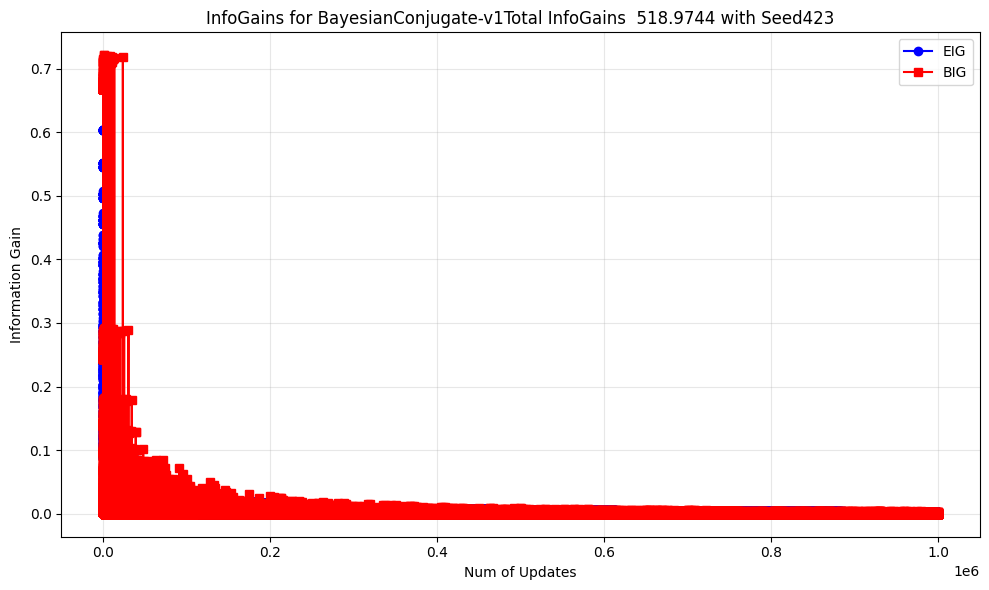

{'NUM_ENVS': 1, 'NUM_STEPS': 4, 'SAC_D_STEPS': 4, 'SAC_STEP_SIZE': 1.0, 'SEED': 424, 'TOTAL_TIMESTEPS': 1000000, 'NUM_HIDDEN': 512, 'TX': 'adamw', 'LR': 0.002, 'OPT_STEPS': 8, 'ENV_NAME': 'FrozenLake-v1', 'MODEL_NAME': 'BayesianConjugate-v1', 'DEBUG': False, 'NUM_UPDATES': 250000}


/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


data shape: Transition(obs=(250000, 1, 4), action=(250000, 1, 4), reward=(250000, 1, 4), next_obs=(250000, 1, 4), done=(250000, 1, 4), info={'kl': (250000, 1, 4), 'mi': (250000, 1, 4), 'next_state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4)), 'state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4))})


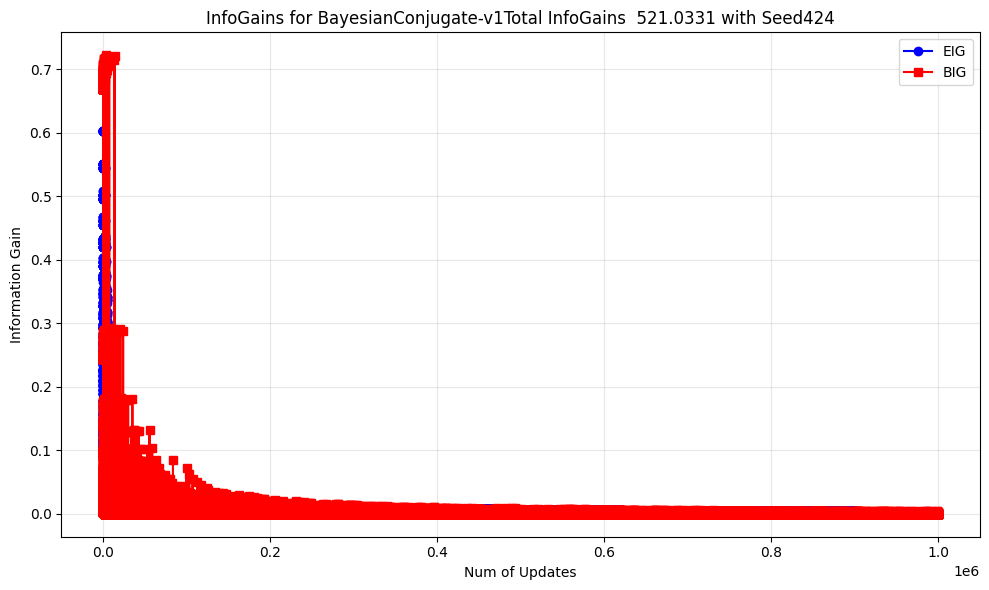

{'NUM_ENVS': 1, 'NUM_STEPS': 4, 'SAC_D_STEPS': 4, 'SAC_STEP_SIZE': 1.0, 'SEED': 425, 'TOTAL_TIMESTEPS': 1000000, 'NUM_HIDDEN': 512, 'TX': 'adamw', 'LR': 0.002, 'OPT_STEPS': 8, 'ENV_NAME': 'FrozenLake-v1', 'MODEL_NAME': 'BayesianConjugate-v1', 'DEBUG': False, 'NUM_UPDATES': 250000}


/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


data shape: Transition(obs=(250000, 1, 4), action=(250000, 1, 4), reward=(250000, 1, 4), next_obs=(250000, 1, 4), done=(250000, 1, 4), info={'kl': (250000, 1, 4), 'mi': (250000, 1, 4), 'next_state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4)), 'state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4))})


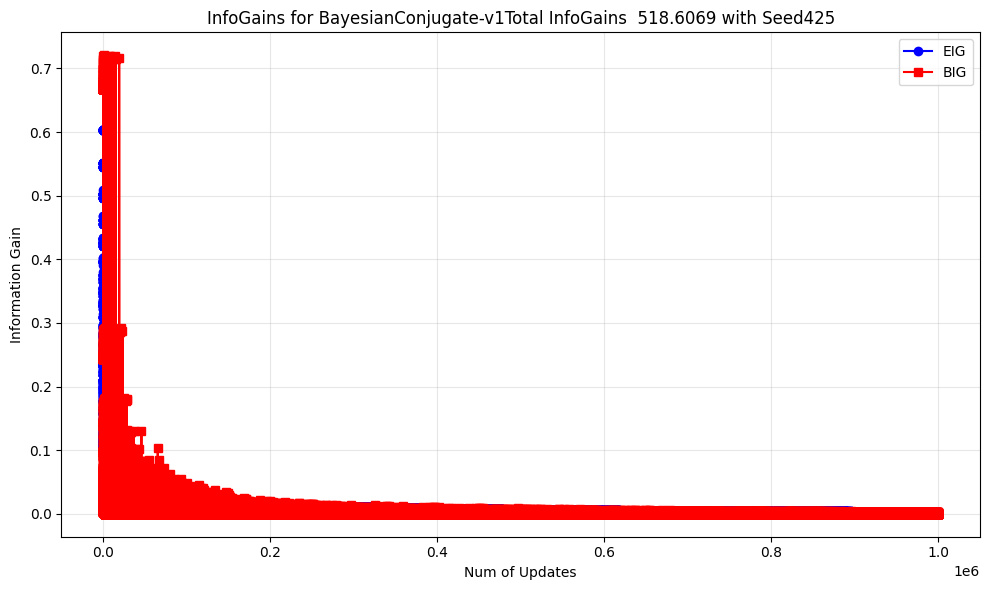

{'NUM_ENVS': 1, 'NUM_STEPS': 4, 'SAC_D_STEPS': 4, 'SAC_STEP_SIZE': 1.0, 'SEED': 426, 'TOTAL_TIMESTEPS': 1000000, 'NUM_HIDDEN': 512, 'TX': 'adamw', 'LR': 0.002, 'OPT_STEPS': 8, 'ENV_NAME': 'FrozenLake-v1', 'MODEL_NAME': 'BayesianConjugate-v1', 'DEBUG': False, 'NUM_UPDATES': 250000}


/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


data shape: Transition(obs=(250000, 1, 4), action=(250000, 1, 4), reward=(250000, 1, 4), next_obs=(250000, 1, 4), done=(250000, 1, 4), info={'kl': (250000, 1, 4), 'mi': (250000, 1, 4), 'next_state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4)), 'state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4))})


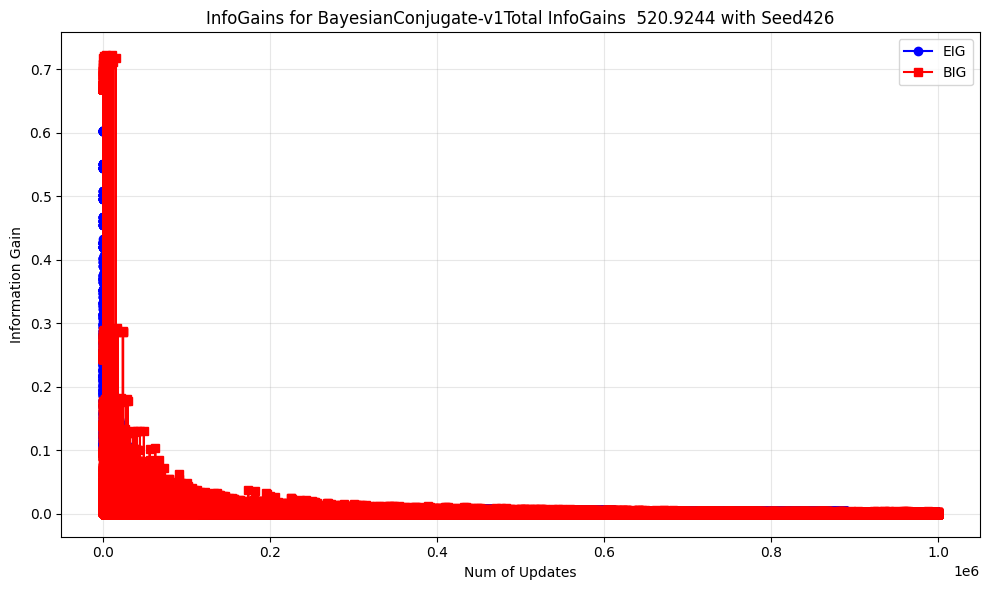

{'NUM_ENVS': 1, 'NUM_STEPS': 4, 'SAC_D_STEPS': 4, 'SAC_STEP_SIZE': 1.0, 'SEED': 427, 'TOTAL_TIMESTEPS': 1000000, 'NUM_HIDDEN': 512, 'TX': 'adamw', 'LR': 0.002, 'OPT_STEPS': 8, 'ENV_NAME': 'FrozenLake-v1', 'MODEL_NAME': 'BayesianConjugate-v1', 'DEBUG': False, 'NUM_UPDATES': 250000}


/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


data shape: Transition(obs=(250000, 1, 4), action=(250000, 1, 4), reward=(250000, 1, 4), next_obs=(250000, 1, 4), done=(250000, 1, 4), info={'kl': (250000, 1, 4), 'mi': (250000, 1, 4), 'next_state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4)), 'state': EnvState(time=(250000, 1, 4), state=(250000, 1, 4))})


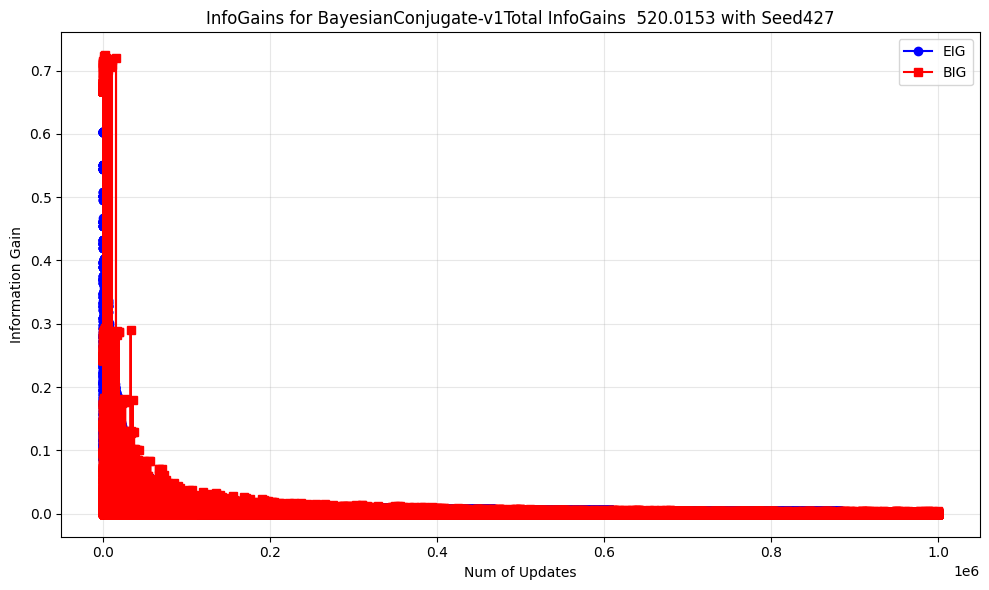

In [ ]:
import jax
import jax.numpy as jnp
jnp.set_printoptions(precision=2,suppress=True)
from jax.scipy.special import digamma, gammaln, kl_div
import flax.linen as nn
import numpy as np
import optax
import time
import flax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
import distrax
import gymnax
import functools
from gymnax.environments import spaces
from gymnax.wrappers import FlattenObservationWrapper, LogWrapper
import matplotlib.pyplot as plt


import optax
from flax.nnx.helpers import TrainState

class MyTrainState(TrainState):
    vars: nnx.Variable
    others: nnx.State

    @property
    def need_train(self):
        return len(self.params) > 0

is_trainable = lambda path, node: ( node.type == nnx.Param and
    True in [ 'trainable' in t for t in path] )

def train_state_from_model(model,tx=optax.adam(0.02)):
    graphdef, trainable_params, vars, others = nnx.split(model,is_trainable, nnx.Variable,...)

    state = MyTrainState.create(
      tx=tx,
      graphdef=graphdef,
      params=trainable_params,
      vars=vars,
      others=others,
    )
    return state

def train_state_update_model(model,state):
    graphdef, trainable_params, vars, others = nnx.split(model,is_trainable, nnx.Variable,...)
    return state.replace(vars=vars,others=others)

def model_from_train_state(state):
    return nnx.merge(state.graphdef, state.params, state.vars,state.others)


# NUM_UPDATES x NUM_ENVS x NUM_STEPS
class Transition(NamedTuple):
    obs: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    next_obs: jnp.ndarray
    done: jnp.ndarray
    info: {}


def make_train(config):

    config["NUM_UPDATES"] = (config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"]// config["NUM_ENVS"])

    num_states = 16
    num_actions = 4

    rng = jax.random.PRNGKey(config["SEED"])
    rng_batch = jax.random.split(rng, config["NUM_ENVS"])

    if config["ENV_NAME"] == "FrozenLake-v1":
        env = FrozenLake()
    else:
        env, _ = gymnax.make(config["ENV_NAME"])

    if config["MODEL_NAME"] == "BayesianConjugate-v1":
      #count based bayesian MI maxmizer
        model = BayesianExplorer(num_states,num_actions)
    elif config["MODEL_NAME"] == "RandomBayesianConjugate-v1":
      #random, but keep counting
        model = RandomBayesianExplorer(num_states,num_actions)
    elif config["MODEL_NAME"] == "DeepBayesianConjugate-v1":
      #use NN to estimate MI and maximize neural MI, but keep counting
        model = DeepBayesianExplorer(num_states,num_actions,num_hidden=config["NUM_HIDDEN"])
    elif config["MODEL_NAME"] == "DeepSACBayesianConjugate-v1":
      #use NN to estimate MI and maximize neural MI with actor, but keep counting
        model = DeepSACBayesianExplorer(num_states,num_actions,num_hidden=config["NUM_HIDDEN"])
    elif config["MODEL_NAME"] == "DynamicSACBayesianExplorer-v1":
      #use NN to estimate MI and maximize neural MI with actor, but keep counting
        model = DynamicSACBayesianExplorer(num_states,num_actions,
                                           num_hidden=config["NUM_HIDDEN"],
                                           n_steps=config["SAC_D_STEPS"],
                                           step_size=config["SAC_STEP_SIZE"])
    elif config["MODEL_NAME"] == "DeepRandomBayesianConjugate-v1":
      #random, but keep counting and estimate MI with NN
        model = DeepRandomBayesianExplorer(num_states,num_actions,num_hidden=config["NUM_HIDDEN"])
    elif config["MODEL_NAME"] == "StateCountingConjugate-v1":
        model = StateCountingExplorer(num_states,num_actions)
    elif config["MODEL_NAME"] == "CountingBayesianConjugate-v1":
        model = CountingBayesianExplorer(num_states,num_actions)
    else:
        model = None
    manager = UnsupervisedRolloutWrapper(env,num_env_steps=config["NUM_STEPS"])

    @nnx.jit
    def _train_step(state:MyTrainState, rng_loss, obs, action,next_obs,done,info):

      def loss_fn(graphdef,params,vars,others):
        model = nnx.merge(graphdef, params, vars,others)
        return model.loss(rng_loss,obs, action,next_obs,done,info).mean()

      def opt_step(state,unused):
        grads = jax.grad(loss_fn,1)(state.graphdef, state.params, state.vars,state.others)
        return state.apply_gradients(grads=grads),None
      state, _ = jax.lax.scan(opt_step, state, None, config["OPT_STEPS"])

      return state
    @nnx.jit
    def _rollout_and_update_step(runner_state, unused):
        # we have to use train_state for jax.lax.scan
        train_state, env_state, rng_batch = runner_state

        model = model_from_train_state(train_state)
        rng_batch, rng_step,rng_update,rng_loss = batch_random_split(rng_batch,4)

        rollout_results = manager.batch_rollout( rng_step, model, env_state)
        obs, action, reward, next_obs, done,info, cum_ret = rollout_results
        next_state = info["next_state"]
        last_state = EnvState(
            time=next_state.time[:,-1],  # Becomes shape (2,)
            state=next_state.state[:,-1]  # Becomes shape (2,)
        )
        # obs: num_envs x
        transition = Transition(obs, action, reward, next_obs, done,info)

        update_info = manager.batch_update(rng_update, model,obs, action,next_obs,done,info)
        info.update(update_info)
        train_state = train_state_update_model(model,train_state)
        if train_state.need_train:
            train_state = _train_step(train_state, rng_loss, obs, action,next_obs,done,info)
        #works for tensors
        runner_state = (train_state, last_state, rng_batch)
        return runner_state, transition

    def train(rng_batch,model,manager):
        # training loop

        rng_batch,  rng_reset = batch_random_split(rng_batch, 2)
        start_state = manager.batch_reset(rng_reset)

        if config["TX"] == "adamw":
            tx = optax.adamw(config["LR"])
        elif config["TX"] == "sgd":
            tx = optax.sgd(config["LR"])
        train_state = train_state_from_model(model,tx)
      #  rng, _rng = jax.random.split(rng)
        runner_state = (train_state, start_state, rng_batch)
        runner_state, transitions = jax.lax.scan(_rollout_and_update_step, runner_state, None, config["NUM_UPDATES"])

        return {"runner_state": runner_state, "transitions": transitions}
        # return {"runner_state": runner_state, "collect_data": collect_data, "max_mi_history": max_mi_history}

    return train,model, manager,rng_batch

def experiment(config):
    print(config)
    train_fn,model, manager,rng_batch = make_train(config)
    train_jit = nnx.jit(train_fn)

 #   show_variable(model,"explorer before")
    out = jax.block_until_ready(train_fn(rng_batch,model,manager))
    #data shape: rollout groups = [TOTAL_TIMESTEPS//NUM_ENVS //NUM_STEPS] x NUM_ENVS x NUM_STEPS
    print("data shape:", jax.tree_util.tree_map(lambda x: x.shape, out["transitions"]))

    train_state, env_state, rng_batch = out["runner_state"]

    model = model_from_train_state(train_state)
    #print ("model",model)

  #  show_variable(model,"explorer after")
  #  print ("out[transitions].info[MI]",out["transitions"].info["mi"].mean(axis=(1,2),keepdims=False))
 #   print ("out[transitions].info[KL]",out["transitions"].info["kl"].mean(axis=(1,2),keepdims=False))
  #  if "deepkl" in out["transitions"].info:
  #      print ("out[transitions].info[deepkl]",out["transitions"].info["deepkl"].mean(axis=(1,2),keepdims=False))
  #  print ("out[transitions]done",out["transitions"].done.mean(axis=(1,2),keepdims=False))


    import matplotlib.pyplot as plt

    # Create figure and axis
    plt.figure(figsize=(10, 6))
    # Sample JAX NumPy arrays (replace these with your actual arrays)
    #  print (out["transitions"].info)
    eig_array = out["transitions"].info["mi"].reshape(-1)
    big_array = out["transitions"].info["kl"].reshape(-1)
    if "deepkl" in out["transitions"].info:
        dkl_array = out["transitions"].info["deepkl"].reshape(-1)

    # Plot both arrays
    plt.plot(eig_array, label='EIG', marker='o', linestyle='-', color='blue')
    plt.plot(big_array, label='BIG', marker='s', linestyle='-', color='red')
    if "deepkl" in out["transitions"].info:
        plt.plot(dkl_array, label='DeepIG', marker='^', linestyle='-', color='green')
    #plt.plot(done_array, label='Done', marker='^', linestyle='-', color='green')

    # Add labels and title
    plt.xlabel('Num of Updates')
    plt.ylabel('Information Gain')
    Title = "InfoGains for "+  config["MODEL_NAME"]
    Title = Title + "Total InfoGains" +"{:10.4f}".format(big_array.sum().item())
    Title = Title +  " with Seed" +str(config["SEED"])
    plt.title(Title)

    # Add grid and legend
    plt.grid(alpha=0.3)
    plt.legend()
    # Show the plot
   # plt.ylim(0, 0.8)
    plt.tight_layout()
    plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return out, big_array,Title.replace(" ","_")+'.pdf'

config = {
    "NUM_ENVS": 1,    #parallel envs
    "NUM_STEPS": 4,   #steps of roll out between update
    "SAC_D_STEPS": 4,
    "SAC_STEP_SIZE": 1.0,
    "SEED": 42131,         #highly stochastic
    "TOTAL_TIMESTEPS": 1000000,   #total steps for all envs
    "NUM_HIDDEN":512,
    "TX":"adamw",
    "LR":2e-3,
    "OPT_STEPS":8,
    "ENV_NAME": "FrozenLake-v1",
    "MODEL_NAME": "BayesianConjugate-v1",
    "DEBUG": False,
}
result = {}
pdfs = []
collect_data = {}
#for i in [8,16,32,64,128,256]:
  #  result[i] = {}
# for MODEL_NAME in ["BayesianConjugate-v1","DeepBayesianConjugate-v1","DynamicSACBayesianExplorer-v1",
#                    "DeepSACBayesianConjugate-v1","DeepRandomBayesianConjugate-v1"]:
# for MODEL_NAME in ["StateCountingConjugate-v1","CountingBayesianConjugate-v1","BayesianConjugate-v1", "DeepBayesianConjugate-v1"]:
for MODEL_NAME in ["BayesianConjugate-v1"]:
    config["MODEL_NAME"] = MODEL_NAME
    result[MODEL_NAME] =[]
    for seed in range(5):
        config["SEED"] = 423+seed
        out , big ,pdf = experiment(config)
        collect_data[MODEL_NAME + "_" + str(config["SEED"])] = out["transitions"]
        result[MODEL_NAME].append(big)
        pdfs.append(pdf)



In [ ]:
%pip install minari
%pip install d4rl
%pip install gymnasium

In [ ]:
# class Transition(NamedTuple):
#     obs: jnp.ndarray
#     action: jnp.ndarray
#     reward: jnp.ndarray
#     next_obs: jnp.ndarray
#     done: jnp.ndarray
#     info: {}

models = ["StateCountingConjugate-v1","BayesianConjugate-v1","DeepBayesianConjugate-v1","DynamicSACBayesianExplorer-v1",
                   "DeepSACBayesianConjugate-v1","DeepRandomBayesianConjugate-v1"]

from minari import create_dataset_from_buffers
from minari.dataset.step_data import StepData
from minari.data_collector.episode_buffer import EpisodeBuffer
import gymnasium as gym

env = gym.make("FrozenLake-v1")


def concatenate_data(data_list):
  concatenated = np.concatenate(data_list, axis=0)
  return concatenated.flatten()


def search_goal_index(reward):
  for i in range(len(reward)):
    if reward[i] == 1:
      return i
  return "not reached"


sum = 0
count = 0

for seed in range(200):
  suffix = seed + 423
  name = "BayesianConjugate-v1_"+str(suffix)
  reward = concatenate_data(collect_data[name][2])
  goal_index = search_goal_index(reward)
  if goal_index != "not reached":
    print(seed, f"total timesteps: {len(reward)}", f"goal_index: {goal_index}")
    count += 1
    sum += goal_index
  else:
    print("not reached")

print(sum / count)






# obs = concatenate_data(collect_data[name][0])
# action = concatenate_data(collect_data[name][1])
# reward = concatenate_data(collect_data[name][2])
# next_obs = concatenate_data(collect_data[name][3])
# done = concatenate_data(collect_data[name][4])



# obs = concatenate_data([collect_data[model+"_423"].obs for model in models])
# actions = concatenate_data([collect_data[model+"_423"].action for model in models])
# current_episode = EpisodeBuffer(id=1, seed=1)
# current_stepdata = StepData()
# current_stepdata["observation"] = obs

# current_stepdata["action"] = action
# current_stepdata["reward"] = reward
# current_stepdata["termination"] = done
# current_stepdata["truncation"] = done
# current_stepdata["info"] = info

# current_episode = current_episode.add_step_data(current_stepdata)

# buffer_list = []
# buffer_list.append(current_episode)

# dataset = create_dataset_from_buffers(dataset_id="Frozenlaketest3", buffer=buffer_list, env=env)



In [ ]:
def random_rollout_sample(num_steps, seed):

  rng = jax.random.PRNGKey(seed)
  alphas = jnp.zeros((16, 4, 16))
  # Define rollout manager for pendulum env
  manager = CustomRolloutWrapper(FrozenLake(),num_env_steps=num_steps)

  # Simple single episode rollout for policy
  obs, action, reward, next_obs, done,info, cum_ret = manager.single_rollout(rng,None)

  # Multiple rollouts for same network (different rng, e.g. eval)

  return obs, action, reward, next_obs, done,info

sum = 0
count = 0
for i in range(100):
  seed = 723 + i
  obs, action, reward, next_obs, done,info = random_rollout_sample(num_steps=128, seed=seed)
  goal_index = search_goal_index(reward)
  if goal_index != "not reached":
    count += 1
    sum += goal_index
  print("Random", seed, f"total timesteps: {len(reward)}", f"goal_index: {goal_index}")

print(sum / count)




jax Q-learning

In [ ]:
from functools import partial

import jax.numpy as jnp
from jax import jit

from .base_agent import BaseAgent

class Q_learning(BaseAgent):
    def __init__(
        self, key, n_states, n_actions, discount, learning_rate,
    ) -> None:
        super(Q_learning, self).__init__(
            key,
            n_states,
            n_actions,
            discount,
        )
        self.learning_rate = learning_rate

    @partial(jit, static_argnums=(0,))
    def update(self, state, action, reward, done, next_state, q_values):
        update = q_values[state[0], state[1], action]
        update += self.learning_rate * (
            reward + self.discount * jnp.max(q_values[tuple(next_state)]) - update
        )
        return q_values.at[state[0], state[1], action].set(update)

ImportError: attempted relative import with no known parent package

Table-based Q-learning

In [ ]:
import numpy as np


NUM_STATES = 16
NUM_ACTIONS = 4


ALPHA = 0.1
GAMMA = 0.99

Q = np.zeros((NUM_STATES, NUM_ACTIONS))



for i in range(len(obs)):
  c_obs, c_action, c_reward, c_next_obs, c_done = int(obs[i]), int(action[i]), int(reward[i]), int(next_obs[i]), bool(done[i])
  terminator = 1 if c_done else 0
  Q[c_obs, c_action] += ALPHA * (c_reward + (1-terminator) * GAMMA * np.max(Q[c_next_obs]) - Q[c_obs, c_action])


# episodes = [
#     [(0, 1, -1, 1), (1, 2, -1, 5), (5, 3, 10, 5)],
#     [(0, 2, -1, 4), (4, 1, -1, 0)],

# ]

# for episode in episodes:
#     for state, action, reward, next_state in episode:

#         Q[state, action] += ALPHA * (reward + GAMMA * np.max(Q[next_state]) - Q[state, action])


print("Final Q-table:")
print(Q)


def get_optimal_policy(Q):
    policy = np.zeros(NUM_STATES, dtype=int)
    for state in range(NUM_STATES):
        policy[state] = np.argmax(Q[state])
    return policy

policy = get_optimal_policy(Q)
print("Optimal policy (action for each state):")
print(policy)


# multi table
# import numpy as np

# NUM_STATES = 16
# NUM_ACTIONS = 4
# ALPHA = 0.1
# GAMMA = 0.99


# num_agents = 2

# Q = [np.zeros((NUM_STATES, NUM_ACTIONS)) for _ in range(num_agents)]


# for agent_id in range(num_agents):
#     for i in range(len(obs)):
#         current_Q = Q[agent_id]
#         print(current_Q.shape)
#         c_obs, c_action, c_reward, c_next_obs, c_done = int(obs[i]), int(action[i]), int(reward[i]), int(next_obs[i]), bool(done[i])
#         terminator = 1 if c_done else 0
#         td_target = c_reward + (1-terminator) * GAMMA * np.max(current_Q[c_next_obs])
#         print(td_target)
#         td_error = td_target - current_Q[c_obs, c_action]
#         current_Q[c_obs, c_action] += ALPHA * td_error

# # print("Final Q-tables for each agent:")
# # for i in range(num_agents):
# #     print(f"Agent {i}:")
# #     print(Q[i])

# def get_optimal_policy(Q_table):
#     policy = np.zeros(NUM_STATES, dtype=int)
#     for state in range(NUM_STATES):
#         policy[state] = np.argmax(Q_table[state])
#     return policy

# # 获取每个智能体的最优策略
# policies = [get_optimal_policy(Q_table) for Q_table in Q]
# print("\nOptimal policies for each agent:")
# for i in range(num_agents):
#     print(f"Agent {i}: {policies[i]}")

Final Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Optimal policy (action for each state):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Table-based IQL

In [ ]:
import numpy as np

# 假设轨迹数据的格式为episodes列表，每个episode包含(s, a, r, s', done)元组
# 示例数据（需替换为真实数据）
episodes = [
    [(0, 1, 0.0, 4, False), (4, 2, 0.0, 8, False), (8, 1, 0.0, 9, False), (9, 2, 1.0, 9, True)],
    [(0, 2, 0.0, 1, False), (1, 2, 0.0, 2, False), (2, 1, 0.0, 6, False), (6, 0, 1.0, 6, True)]
]

# 将episodes展平为转移列表
transitions = [t for episode in episodes for t in episode]

# 环境参数
n_states = 16  # FrozenLake 4x4
n_actions = 4

# 初始化Q表
Q = np.zeros((n_states, n_actions))

# 超参数
alpha = 0.1     # 学习率
gamma = 0.99    # 折扣因子
tau = 0.9       # Expectile参数
num_epochs = 1000  # 训练轮数

def compute_expectile(q_values, tau, lr=0.01, num_steps=100):
    """计算给定Q值的tau-expectile"""
    if len(q_values) == 0:
        return 0.0
    v = np.mean(q_values)
    for _ in range(num_steps):
        residuals = q_values - v
        weights = np.where(residuals >= 0, tau, (1 - tau))
        grad = 2 * np.mean(weights * residuals)
        v -= lr * grad
    return v

# 训练循环
for epoch in range(num_epochs):
    for transition in transitions:
        s, a, r, s_prime, done = transition

        # 计算下一个状态的V值
        q_values_s_prime = Q[s_prime]
        v_s_prime = compute_expectile(q_values_s_prime, tau)

        # 计算目标Q值
        target = r + gamma * v_s_prime * (not done)

        # 更新Q表
        Q[s, a] = (1 - alpha) * Q[s, a] + alpha * target

# 提取最优策略
policy = np.argmax(Q, axis=1)
print("Learned policy:", policy)


Learned policy: [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]


IQL AC

In [ ]:
import csv
from datetime import datetime
import json
from pathlib import Path
import random
import string
import sys

import numpy as np
import torch
import torch.nn as nn


DEFAULT_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class Squeeze(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.squeeze(dim=self.dim)


def mlp(dims, activation=nn.ReLU, output_activation=None, squeeze_output=False):
    n_dims = len(dims)
    assert n_dims >= 2, 'MLP requires at least two dims (input and output)'

    layers = []
    for i in range(n_dims - 2):
        layers.append(nn.Linear(dims[i], dims[i+1]))
        layers.append(activation())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    if output_activation is not None:
        layers.append(output_activation())
    if squeeze_output:
        assert dims[-1] == 1
        layers.append(Squeeze(-1))
    net = nn.Sequential(*layers)
    net.to(dtype=torch.float32)
    return net


def compute_batched(f, xs):
    return f(torch.cat(xs, dim=0)).split([len(x) for x in xs])


def update_exponential_moving_average(target, source, alpha):
    for target_param, source_param in zip(target.parameters(), source.parameters()):
        target_param.data.mul_(1. - alpha).add_(source_param.data, alpha=alpha)


def torchify(x):
    x = torch.from_numpy(x)
    if x.dtype is torch.float64:
        x = x.float()
    x = x.to(device=DEFAULT_DEVICE)
    return x



def return_range(dataset, max_episode_steps):
    returns, lengths = [], []
    ep_ret, ep_len = 0., 0
    for r, d in zip(dataset['rewards'], dataset['terminals']):
        ep_ret += float(r)
        ep_len += 1
        if d or ep_len == max_episode_steps:
            returns.append(ep_ret)
            lengths.append(ep_len)
            ep_ret, ep_len = 0., 0
    # returns.append(ep_ret)    # incomplete trajectory
    lengths.append(ep_len)      # but still keep track of number of steps
    assert sum(lengths) == len(dataset['rewards'])
    return min(returns), max(returns)


# dataset is a dict, values of which are tensors of same first dimension
def sample_batch(dataset, batch_size):
    k = list(dataset.keys())[0]
    n, device = len(dataset[k]), dataset[k].device
    for v in dataset.values():
        assert len(v) == n, 'Dataset values must have same length'
    indices = torch.randint(low=0, high=n, size=(batch_size,), device=device)
    return {k: v[indices] for k, v in dataset.items()}


def evaluate_policy(env, policy, max_episode_steps, deterministic=True):
    obs = env.reset()
    total_reward = 0.
    for _ in range(max_episode_steps):
        with torch.no_grad():
            action = policy.act(torchify(obs), deterministic=deterministic).cpu().numpy()
        next_obs, reward, done, info = env.step(action)
        total_reward += reward
        if done:
            break
        else:
            obs = next_obs
    return total_reward


def set_seed(seed, env=None):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    if env is not None:
        env.seed(seed)


def _gen_dir_name():
    now_str = datetime.now().strftime('%m-%d-%y_%H.%M.%S')
    rand_str = ''.join(random.choices(string.ascii_lowercase, k=4))
    return f'{now_str}_{rand_str}'

class Log:
    def __init__(self, root_log_dir, cfg_dict,
                 txt_filename='log.txt',
                 csv_filename='progress.csv',
                 cfg_filename='config.json',
                 flush=True):
        self.dir = Path(root_log_dir)/_gen_dir_name()
        self.dir.mkdir(parents=True)
        self.txt_file = open(self.dir/txt_filename, 'w')
        self.csv_file = None
        (self.dir/cfg_filename).write_text(json.dumps(cfg_dict))
        self.txt_filename = txt_filename
        self.csv_filename = csv_filename
        self.cfg_filename = cfg_filename
        self.flush = flush

    def write(self, message, end='\n'):
        now_str = datetime.now().strftime('%H:%M:%S')
        message = f'[{now_str}] ' + message
        for f in [sys.stdout, self.txt_file]:
            print(message, end=end, file=f, flush=self.flush)

    def __call__(self, *args, **kwargs):
        self.write(*args, **kwargs)

    def row(self, dict):
        if self.csv_file is None:
            self.csv_file = open(self.dir/self.csv_filename, 'w', newline='')
            self.csv_writer = csv.DictWriter(self.csv_file, list(dict.keys()))
            self.csv_writer.writeheader()

        self(str(dict))
        self.csv_writer.writerow(dict)
        if self.flush:
            self.csv_file.flush()

    def close(self):
        self.txt_file.close()
        if self.csv_file is not None:
            self.csv_file.close()

Counting based Explorer

In [ ]:
import jax
import jax.numpy as jnp
import gym
from functools import partial

class JaxCountingExplorer:
    def __init__(self, env, alpha=1.0, gamma=0.99, lr=0.1, seed=42):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.lr = lr

        # 使用JAX数组初始化
        self.N = jnp.zeros((env.observation_space.n, env.action_space.n))
        self.Q = jnp.zeros((env.observation_space.n, env.action_space.n))
        self.rng = jax.random.PRNGKey(seed)

    @partial(jax.jit, static_argnums=(0,))
    def choose_action(self, state):
        """JIT编译的动作选择函数"""
        exploration_bonus = self.alpha / jnp.sqrt(self.N[state] + 1)
        total_value = self.Q[state] + exploration_bonus
        return jax.random.choice(
            key=self.rng,
            a=jnp.arange(self.env.action_space.n),
            p=(total_value == total_value.max()).astype(jnp.float32)
        )

    @partial(jax.jit, static_argnums=(0,))
    def update(self, state, action, reward, next_state, done):
        """JIT编译的参数更新函数"""
        # 更新计数器
        new_N = self.N.at[state, action].add(1)

        # 计算TD目标
        td_target = reward + (1 - done) * self.gamma * jnp.max(self.Q[next_state])

        # 更新Q值
        new_Q = self.Q.at[state, action].add(
            self.lr * (td_target - self.Q[state, action])
        )

        # 分裂随机数生成器
        _, new_rng = jax.random.split(self.rng)

        return new_N, new_Q, new_rng

    def episode_step(self, carry, _):
        """用于扫描的每步处理函数"""
        state, total_reward, done = carry

        # 选择动作
        action = self.choose_action(state)

        # 环境交互
        next_state, reward, done, _ = self.env.step(action)

        # 更新参数
        self.N, self.Q, self.rng = self.update(state, action, reward, next_state, done)

        # 构建新的carry状态
        new_carry = (next_state, total_reward + reward, done)
        return new_carry, None

# 使用示例
if __name__ == "__main__":
    env = gym.make('FrozenLake-v1', is_slippery=False)
    agent = JaxCountingExplorer(env, alpha=0.5)

    # JAX风格的训练循环
    for _ in range(1000):
        state = env.reset()
        done = False
        total_reward = 0

        # 使用JAX的扫描进行单次迭代
        (final_state, total_reward, _), _ = jax.lax.scan(
            f=agent.episode_step,
            init=(state, total_reward, done),
            xs=None,
            length=100
        )

    # 显示最终策略
    print("Learned Q-table:")
    print(agent.Q.reshape(16, 4))  # 假设4x4地图

TypeError: unhashable type: 'DynamicJaxprTracer'

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal



LOG_STD_MIN = -5.0
LOG_STD_MAX = 2.0


class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256, n_hidden=2):
        super().__init__()
        self.net = mlp([obs_dim, *([hidden_dim] * n_hidden), act_dim])
        self.log_std = nn.Parameter(torch.zeros(act_dim, dtype=torch.float32))

    def forward(self, obs):
        mean = self.net(obs)
        std = torch.exp(self.log_std.clamp(LOG_STD_MIN, LOG_STD_MAX))
        scale_tril = torch.diag(std)
        return MultivariateNormal(mean, scale_tril=scale_tril)
        # if mean.ndim > 1:
        #     batch_size = len(obs)
        #     return MultivariateNormal(mean, scale_tril=scale_tril.repeat(batch_size, 1, 1))
        # else:
        #     return MultivariateNormal(mean, scale_tril=scale_tril)

    def act(self, obs, deterministic=False, enable_grad=False):
        with torch.set_grad_enabled(enable_grad):
            dist = self(obs)
            return dist.mean if deterministic else dist.sample()


class DeterministicPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=256, n_hidden=2):
        super().__init__()
        self.net = mlp([obs_dim, *([hidden_dim] * n_hidden), act_dim],
                       output_activation=nn.Tanh)

    def forward(self, obs):
        return self.net(obs)

    def act(self, obs, deterministic=False, enable_grad=False):
        with torch.set_grad_enabled(enable_grad):
            return self(obs)

In [ ]:
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR


EXP_ADV_MAX = 100.


def asymmetric_l2_loss(u, tau):
    return torch.mean(torch.abs(tau - (u < 0).float()) * u**2)


class ImplicitQLearning(nn.Module):
    def __init__(self, qf, vf, policy, optimizer_factory, max_steps,
                 tau, beta, discount=0.99, alpha=0.005):
        super().__init__()
        self.qf = qf.to(DEFAULT_DEVICE)
        self.q_target = copy.deepcopy(qf).requires_grad_(False).to(DEFAULT_DEVICE)
        self.vf = vf.to(DEFAULT_DEVICE)
        self.policy = policy.to(DEFAULT_DEVICE)
        self.v_optimizer = optimizer_factory(self.vf.parameters())
        self.q_optimizer = optimizer_factory(self.qf.parameters())
        self.policy_optimizer = optimizer_factory(self.policy.parameters())
        self.policy_lr_schedule = CosineAnnealingLR(self.policy_optimizer, max_steps)
        self.tau = tau
        self.beta = beta
        self.discount = discount
        self.alpha = alpha

    def update(self, observations, actions, next_observations, rewards, terminals):
        with torch.no_grad():
            target_q = self.q_target(observations, actions)
            next_v = self.vf(next_observations)

        # v, next_v = compute_batched(self.vf, [observations, next_observations])

        # Update value function
        v = self.vf(observations)
        adv = target_q - v
        v_loss = asymmetric_l2_loss(adv, self.tau)
        self.v_optimizer.zero_grad(set_to_none=True)
        v_loss.backward()
        self.v_optimizer.step()

        # Update Q function
        targets = rewards + (1. - terminals.float()) * self.discount * next_v.detach()
        qs = self.qf.both(observations, actions)
        q_loss = sum(F.mse_loss(q, targets) for q in qs) / len(qs)
        self.q_optimizer.zero_grad(set_to_none=True)
        q_loss.backward()
        self.q_optimizer.step()

        # Update target Q network
        update_exponential_moving_average(self.q_target, self.qf, self.alpha)

        # Update policy
        exp_adv = torch.exp(self.beta * adv.detach()).clamp(max=EXP_ADV_MAX)
        policy_out = self.policy(observations)
        if isinstance(policy_out, torch.distributions.Distribution):
            bc_losses = -policy_out.log_prob(actions)
        elif torch.is_tensor(policy_out):
            assert policy_out.shape == actions.shape
            bc_losses = torch.sum((policy_out - actions)**2, dim=1)
        else:
            raise NotImplementedError
        policy_loss = torch.mean(exp_adv * bc_losses)
        self.policy_optimizer.zero_grad(set_to_none=True)
        policy_loss.backward()
        self.policy_optimizer.step()
        self.policy_lr_schedule.step()

In [ ]:
# prompt: get sum of bigs from result dictionary, and make a 2D plot

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'result' dictionary is available from the previous code execution

# Data processing for the plot
hidden_sizes = sorted(result.keys())
num_steps_values = sorted(result[hidden_sizes[0]].keys())

sum_bigs_data = {}
for hidden_size in hidden_sizes:
    sum_bigs_data[hidden_size] = {}
    for num_steps in num_steps_values:
        sum_bigs = np.mean(result[hidden_size][num_steps], axis=0)  # averaged across seeds
        sum_bigs_data[hidden_size][num_steps] = np.sum(sum_bigs)


# Plotting
plt.figure(figsize=(10, 6))

for hidden_size in hidden_sizes:
  y_values = [sum_bigs_data[hidden_size][num_steps] for num_steps in num_steps_values]
  plt.plot(num_steps_values, y_values, marker='o', label=f'Number of Envs: {hidden_size}')


plt.xlabel('Number of Steps')
plt.ylabel('Sum of BIGs (averaged across seeds)')
plt.title('Bayesian Model Sum of BIGs vs. Number of Steps and Number of Envs')
plt.grid(alpha=0.3)
plt.legend()
plt.xscale('log', base=2) # Set x-axis to logarithmic scale (base 2)
plt.tight_layout()
plt.savefig('sum_of_bigs_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


AttributeError: 'list' object has no attribute 'keys'

In [ ]:

import zipfile
from google.colab import files
# Create a zip file with all your PDFs
with zipfile.ZipFile('pdfs.zip', 'w') as zipf:
    for pdf_file in pdfs:  # your list of PDF files
        zipf.write('/content/'+pdf_file)

# Download the zip file
files.download('pdfs.zip')

In [ ]:

for i in [8,16,32,64,128]:
    for model_name, BIGS in result.items():

        bigs = [big[:i].sum().item() for big in BIGS]
        print(f"up to {i}: {model_name}: {np.mean(bigs):.4f} +- {np.std(bigs):.4f}")

intervals = [0,8,16,32,64,128]
for i in range(len(intervals)-1):
    for model_name, BIGS in result.items():
        bigs = [big[intervals[i]:intervals[i+1]].sum().item() for big in BIGS]
        print(f"from {intervals[i]} to {intervals[i+1]}: {model_name}: {np.mean(bigs):.4f} +- {np.std(bigs):.4f}")

up to 8: BayesianConjugate-v1: 5.3475 +- 0.0000
up to 8: DeepBayesianConjugate-v1: 5.1774 +- 0.3402
up to 8: DynamicSACBayesianExplorer-v1: 5.0099 +- 0.4161
up to 8: DeepSACBayesianConjugate-v1: 5.0099 +- 0.4161
up to 8: DeepRandomBayesianConjugate-v1: 4.7548 +- 0.4334
up to 16: BayesianConjugate-v1: 10.3615 +- 0.4195
up to 16: DeepBayesianConjugate-v1: 9.6770 +- 1.1614
up to 16: DynamicSACBayesianExplorer-v1: 9.0893 +- 0.9070
up to 16: DeepSACBayesianConjugate-v1: 9.1771 +- 0.4273
up to 16: DeepRandomBayesianConjugate-v1: 8.9999 +- 0.9347
up to 32: BayesianConjugate-v1: 18.7514 +- 1.7397
up to 32: DeepBayesianConjugate-v1: 17.9343 +- 1.7207
up to 32: DynamicSACBayesianExplorer-v1: 16.9883 +- 1.8475
up to 32: DeepSACBayesianConjugate-v1: 16.7454 +- 2.2246
up to 32: DeepRandomBayesianConjugate-v1: 15.9245 +- 2.0613
up to 64: BayesianConjugate-v1: 31.4266 +- 2.0477
up to 64: DeepBayesianConjugate-v1: 29.6049 +- 3.7484
up to 64: DynamicSACBayesianExplorer-v1: 27.5551 +- 1.5840
up to 64: D

In [ ]:
# prompt: make plots for visualizing
# for i in [8,16,32,64,128]:
#     for model_name, BIGS in result.items():
#         bigs = [big[:i].sum().item() for big in BIGS]
#         print(f"up to {i}: {model_name}: {np.mean(bigs):.4f} +- {np.std(bigs):.4f}")

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'result' dictionary is available from the previous code execution

plt.figure(figsize=(10, 6))

for model_name, BIGS in result.items():
    for i in [8, 16, 32, 64, 128]:
        bigs = [big[:i].sum().item() for big in BIGS]
        mean_bigs = np.mean(bigs)
        std_bigs = np.std(bigs)
        plt.plot(i, mean_bigs, marker='o', linestyle='-', label=f'{model_name} (up to {i})')
        plt.errorbar(i, mean_bigs, yerr=std_bigs, fmt='o', capsize=5)


plt.xlabel('Number of Steps')
plt.ylabel('Sum of BIGs')
plt.title('Sum of BIGs vs. Number of Steps for Different Models')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('bigs_vs_steps_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:


import time
import matplotlib.pyplot as plt
t0 = time.time()
out = jax.block_until_ready(train_jit(rng))
print(f"time: {time.time() - t0:.2f} s")



# 创建一个子图
fig, ax = plt.subplots(figsize=(10, 8))

# 绘制回报
ax.plot(out["collect_data"]["metric"]["returned_episode_returns"].mean(-1).reshape(-1))
ax.set_xlabel("Update Step")
ax.set_ylabel("Return")
ax.set_title("Episode Returns")

plt.tight_layout()
plt.show()


# 在训练完成后绘制 max_mi 的变化
max_mi_data = out["collect_data"]["mi"]  # 提取 mi 数据
max_mi_data = max_mi_data.reshape(-1, max_mi_data.shape[-1])  # 将数据展平为 (num_updates, num_states)

print("max_mi_data shape:", max_mi_data.shape)
print("max_mi_data values:", max_mi_data)

# 绘制每个状态的最大互信息值的变化
plt.figure(figsize=(10, 6))
for s in range(max_mi_data.shape[1]):
    plt.plot(max_mi_data[:, s], label=f"State {s}")
plt.xlabel("Update Step")
plt.ylabel("Max MI")
plt.title("Max MI per State over Time")
plt.legend()
plt.tight_layout()
plt.show()


# 在训练完成后保存数据
np.save('sac_data/obs.npy', np.array(out["collect_data"]["obs"]))
np.save('sac_data/actions.npy', np.array(out["collect_data"]["actions"]))
np.save('sac_data/rewards.npy', np.array(out["collect_data"]["rewards"]))
np.save('sac_data/dones.npy', np.array(out["collect_data"]["dones"]))
np.save('sac_data/returns.npy', np.array(out["collect_data"]["metric"]["returned_episode_returns"]))
np.save('sac_data/mi.npy', np.array(out["collect_data"]["mi"]))






NameError: name 'jax' is not defined